In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import time
import math

In [5]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    torch.fft.fft2,
    torch.fft.fftshift
])

valid_transforms = transforms.Compose([
    transforms.ToTensor(),
    torch.fft.fft2,
    torch.fft.fftshift
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    torch.fft.fft2,
    torch.fft.fftshift
])


# Create training set (with no transformations)
raw_data = datasets.MNIST(root="data", train=True, download=True, transform=None)

# Split the training data into pure training data and validation data (80/20 split)
train_size = int(len(raw_data) * 0.6) # 60% training data
valid_size = int(len(raw_data) * 0.2) # 20% validation data
test_size = len(raw_data)-(train_size+valid_size)

training_data, validation_data, testing_data = torch.utils.data.random_split(raw_data, [train_size, valid_size, test_size])

# Apply the respective transformations to each dataset
training_data.dataset.transform = train_transforms
validation_data.dataset.transform = valid_transforms
testing_data.dataset.transform = test_transforms

# Create test set and define test dataloader
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(validation_data, batch_size=32)
test_loader = DataLoader(testing_data, batch_size=32)

100%|██████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 45529592.08it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 20108846.92it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:03<00:00, 529515.75it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 3178796.72it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



3


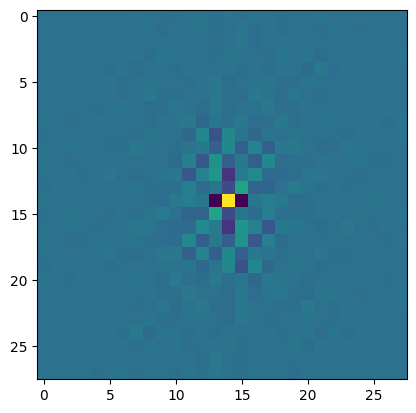

5


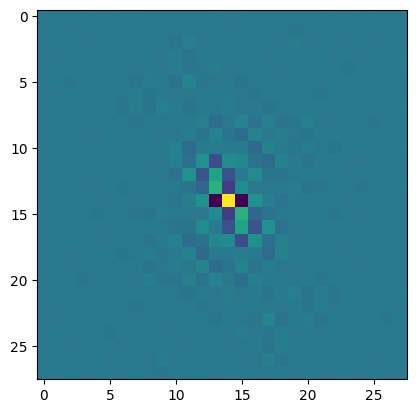

3


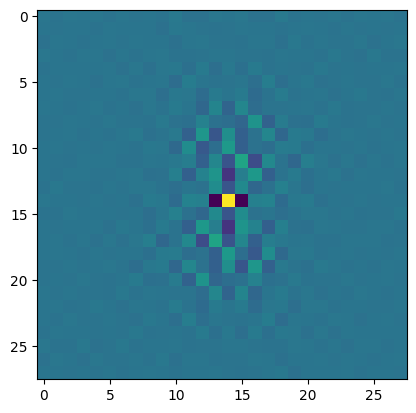

1


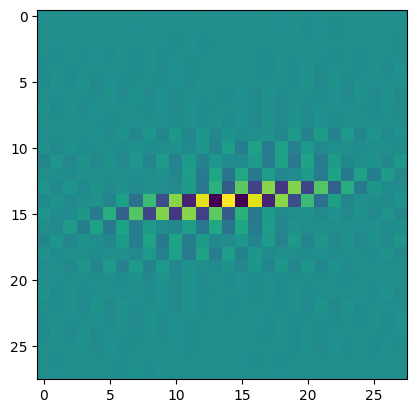

3


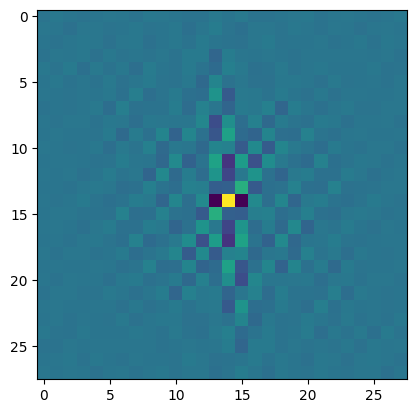

In [11]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
        image = images[i].numpy()
        image = npa.abs(np.real(image) #show the imaginary part of the image
        plt.imshow(image.T.squeeze().T)
        plt.show()
        
# Explore data
show5(train_loader)

In [118]:
# F.dropout is not implemented for complex numbers yet, so here's a workaround  
class dropout_complex(nn.Module): 
    def __init__(self, p=.2): 
        super(dropout_complex, self).__init__()
        self.p = p
          
    def forward(self, x): 
        if x.is_complex():
            mask = torch.nn.functional.dropout(torch.ones_like(x.real), p=self.p)
            return x * mask
        else:
            return torch.nn.functional.dropout(x, p=self.p)

In [119]:
class L2_normalize(nn.Module):
    def __init__(self): 
        super(L2_normalize, self).__init__()
          
    def forward(self, z): 
        return F.normalize(z)

In [120]:
class Net(nn.Module):
    def __init__(self, features=[256, 128], drop_rate=0, momentum=0, learning_rate=.01, weight_decay=0, bias=False):
        """
        The Neural Network class. 
        Note: the optimizer and criterion are specified in this class itself
        ...

        Attributes
        ----------
        features : list of integers, optional, default=[256, 128]
            sets the number of features in the two hidden layers
        drop_rate : float, optional, default=.2
            sets the dropout rate
        momentum : float, optional, default=.9
            sets the momentum coefficient of the optimizer
        learning_rate : float, optional, default=.001
            sets the learning rate of the optimizer

        Methods
        -------
        train_it(epochs=10)
            trains the network, prints loss and accuracy, and returns training and validation loss history as lists
            
        test_it()
            tests the network on the test set and prints loss and accuracy
        """
        
        # Initialize base class
        super().__init__()
        
        #Define parameters
        self.bias = bias
        self.features = features
        self.activation = L2_normalize()
        
        self.drop1 = dropout_complex(p=drop_rate)
        self.z1 = nn.Linear(28*28, features[0], bias=bias, dtype=torch.cfloat)
        
        self.drop2 = dropout_complex(p=drop_rate)
        self.z2 = nn.Linear(features[0], features[1], bias=bias, dtype=torch.cfloat)
            
        self.z3 = nn.Linear(features[1], 10, bias=bias, dtype=torch.cfloat)
        
        self.output = nn.LogSoftmax(dim=1)
        
        # Define optimizer and criterion
        self.optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
        self.criterion = nn.NLLLoss()
    
        
    def forward(self, x):
        x = torch.flatten(x,1)

        x = self.z1(x)
        #x = self.activation(x.abs())/x.abs()*x
        x = self.activation(x)
        x = self.drop1(x)
        
        x = self.z2(x)
        #x = self.activation(x.abs())/x.abs()*x
        x = self.activation(x)
        x = self.drop2(x)
        
        x = self.z3(x)
        x = self.output(x.abs())

        return x
    
    def train_it(self, epochs=10):
        """Trains the network

        Parameters
        ----------
        epochs : str, optional
            Number of epochs in the training run (default is 10)
        """
            
        # First choose the device to do computations on
        device = 'cpu'
        
        # Note: complex numbers are not working on mps. Fixing device to be cpu woth complex numbers
#         if torch.backends.mps.is_available():
#             device = 'mps' # Use MPS (Metal Performance Shader) on Macs
#         elif torch.cuda.is_available():
#             device = 'cuda' # Use Cuda everywhere else when GPU is available
        
        self = self.to(device)
        
        # Initialize data outputs
        train_loss_history = list()
        val_loss_history = list()
        train_accuracy_history = list()
        val_accuracy_history = list()

        for epoch in range(epochs):
            # Training 
            self.train()
            train_loss = 0.0
            train_accuracy = 0.0
            n = 0
            t0 = time.time()

            for inputs, labels in iter(train_loader):
                n += 1
                inputs, labels = inputs.to(device), labels.to(device)
                self.optimizer.zero_grad()

                outputs = self.forward(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                train_loss = (train_loss*(n-1) + loss.item())/n

                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = (top_class == labels.view(*top_class.shape))
                train_accuracy = (train_accuracy*(n-1) +100*torch.mean(equals.type(torch.FloatTensor)).item())/n

            # Validating
            self.eval()
            val_loss = 0.0
            val_accuracy = 0.0
            n = 0

            for inputs, labels in iter(valid_loader):
                n += 1
                inputs, labels = inputs.to(device), labels.to(device)
                self.optimizer.zero_grad()

                outputs = self.forward(inputs)
                loss = self.criterion(outputs, labels)

                val_loss = (val_loss*(n-1) + loss.item())/n

                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = (top_class == labels.view(*top_class.shape))
                val_accuracy = (val_accuracy*(n-1) +100*torch.mean(equals.type(torch.FloatTensor)).item())/n

            train_loss_history.append(train_loss)
            train_accuracy_history.append(train_accuracy)

            val_loss_history.append(val_loss)
            val_accuracy_history.append(val_accuracy)

            print("===============================")
            print("Epoch {}/{} completed in {} seconds on {}".format(epoch+1, epochs, time.time()-t0, device))
            print("Training Loss = {}".format(train_loss))
            print("Validation Loss = {}".format(val_loss))
            print("Training Accuracy = {}%".format(train_accuracy))
            print("Validation Accuracy = {}%".format(val_accuracy))
             
 
        return train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history
    
    def test_it(self):
        """Runs a quick test on the Testing Set and prints loss and accuracy"""
        # First choose the device to do computations on
        device = 'cpu'
#         if torch.backends.mps.is_available():
#             device = 'mps' # Use MPS (Metal Performance Shader) on Macs
#         elif torch.cuda.is_available():
#             device = 'cuda' # Use Cuda everywhere else when GPU is available
        
        self = self.to(device)
        self.eval()
        test_loss = 0.0
        test_accuracy = 0.0
        n = 0

        for inputs, labels in iter(test_loader):
            n += 1
            inputs, labels = inputs.to(device), labels.to(device)
            self.optimizer.zero_grad()

            outputs = self.forward(inputs)
            loss = self.criterion(outputs, labels)

            test_loss = (test_loss*(n-1) + loss.item())/n

            ps = torch.exp(outputs)
            top_p, top_class = ps.topk(1, dim=1)
            equals = (top_class == labels.view(*top_class.shape))
            test_accuracy = (test_accuracy*(n-1) +100*torch.mean(equals.type(torch.FloatTensor)).item())/n

        print("===============================")
        print("Test Loss = {}".format(test_loss))
        print("Test Accuracy = {}%".format(test_accuracy))
        print("===============================")



Epoch 1/100 completed in 4.871129035949707 seconds on cpu
Training Loss = 1.35879469537735
Validation Loss = 0.8741406574249267
Training Accuracy = 79.67500000000003%
Validation Accuracy = 88.25000000000006%
Epoch 2/100 completed in 4.877985954284668 seconds on cpu
Training Loss = 0.6944891260729895
Validation Loss = 0.5727007369995121
Training Accuracy = 89.12777777777772%
Validation Accuracy = 90.0083333333333%
Epoch 3/100 completed in 5.014364004135132 seconds on cpu
Training Loss = 0.504542555385166
Validation Loss = 0.46538911962509155
Training Accuracy = 90.60277777777786%
Validation Accuracy = 90.57499999999996%
Epoch 4/100 completed in 4.606979131698608 seconds on cpu
Training Loss = 0.41725656359725516
Validation Loss = 0.3982437396446865
Training Accuracy = 91.50833333333335%
Validation Accuracy = 91.64166666666668%
Epoch 5/100 completed in 4.511026859283447 seconds on cpu
Training Loss = 0.3645040172338487
Validation Loss = 0.3580334889888765
Training Accuracy = 92.266666666

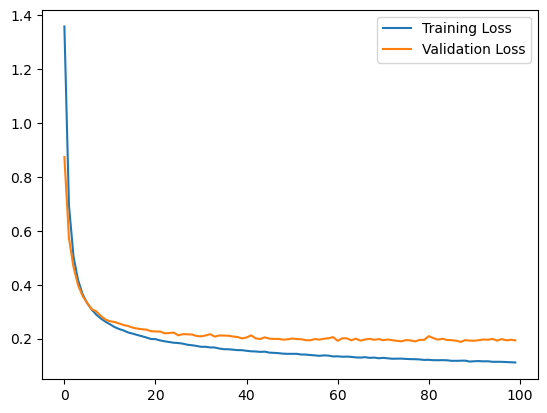

In [122]:
net = Net(features=[200,80], drop_rate=.2, learning_rate=.01, momentum=.8, bias=True)
train_loss_history, val_loss_history, train_acc_history, val_acc_history = net.train_it(epochs=100)

plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

In [123]:
net.test_it()

Test Loss = 0.1942470683380962
Test Accuracy = 94.11666666666663%
